In [32]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse, Circle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import pygmmis
from sklearn.cluster import KMeans
import json
import pickle
import matplotlib.gridspec as gridspec

In [33]:
vphi_data = 'df_v_final.fits'

with fits.open(vphi_data) as hdul:
    data = hdul[1].data  
    
    df_v = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [34]:
df_v = df_v[np.abs(df_v['Z']) < 2.5]
df_v = df_v.dropna(subset=["v_R", "v_phi", "v_R_uncertainty", "v_phi_uncertainty", "v_Z", "v_Z_uncertainty"])

In [35]:
import pandas as pd
from tqdm import tqdm

def filter_metallicity_bin(df, min_mh, max_mh):
    """
    Filter the dataframe to get stars in the specified metallicity range.
    Args:
    - df: The dataframe containing the data.
    - min_mh: The minimum metallicity value.
    - max_mh: The maximum metallicity value.
    
    Returns:
    - df_bin: The filtered dataframe containing only the stars in the metallicity range.
    """
    df_bin = df[(df['mh_xgboost'] >= min_mh) & (df['mh_xgboost'] < max_mh)]
    return df_bin

df_vmp = filter_metallicity_bin(df_v,-3,-2)
df_imp = filter_metallicity_bin(df_v,-2,-1.6)
df_mp1 = filter_metallicity_bin(df_v,-1.6,-1.3)
df_mp2 = filter_metallicity_bin(df_v,-1.3,-1)

In [36]:
with open("gmm_vmp.pkl", "rb") as f:
    gmm_vmp = pickle.load(f)

with open("gmm_imp.pkl", "rb") as f:
    gmm_imp = pickle.load(f)

with open("gmm_mp1.pkl", "rb") as f:
    gmm_mp1 = pickle.load(f)

with open("gmm_mp2.pkl", "rb") as f:
    gmm_mp2 = pickle.load(f)

In [37]:
def generate_mock_stars(gmm, num_samples):
    """Generates mock stars from a fitted GMM."""
    mock_data = gmm.draw(num_samples)
    return mock_data[:, :2]  # Extract v_R and v_phi

def compute_residuals(df_bin, gmm, bins=100, x_limits=(-400, 400), y_limits=(-400, 400)):
    """Computes normalised residuals between the observed data and mock GMM data."""
    df_filtered = df_bin.dropna(subset=["v_R", "v_phi"])
    
    # Generate mock stars from GMM
    mock_stars = generate_mock_stars(gmm, len(df_filtered))
    
    # Compute 2D histograms
    H_obs, xedges, yedges = np.histogram2d(df_filtered["v_R"], df_filtered["v_phi"], bins=bins, range=[x_limits, y_limits])
    H_mock, _, _ = np.histogram2d(mock_stars[:, 0], mock_stars[:, 1], bins=bins, range=[x_limits, y_limits])

    # Compute normalised residual
    H_residual = (H_obs - H_mock) / (H_obs + H_mock + 1e-5)  # Avoid division by zero

    return H_residual, xedges, yedges

/var/folders/p3/pkt6pdhs7fq9ksxkhmbp2_xr0000gn/T/ipykernel_16156/559136335.py:20: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(right=0.85)  # Leave space for the colorbar



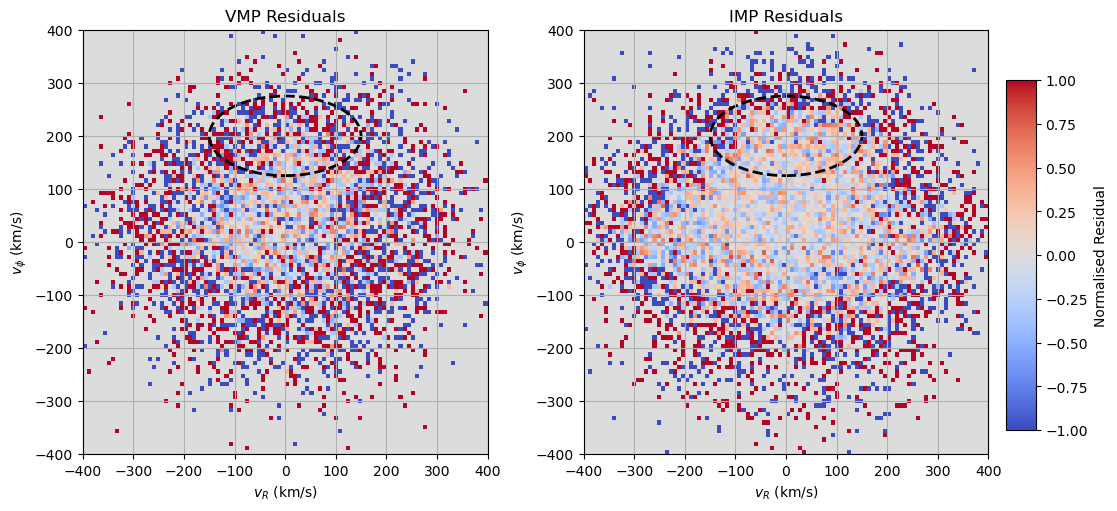

In [38]:
def plot_residuals(df_vmp, df_imp, gmm_vmp, gmm_imp, bins=100):
    """
    Plots normalised residuals for VMP and IMP bins with an **external** colorbar.

    Args:
    - df_vmp, df_imp: DataFrames for the VMP and IMP bins.
    - gmm_vmp, gmm_imp: Corresponding fitted GMMs.
    - bins: Number of bins for histograms.
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

    # Compute residuals
    H_residual_vmp, xedges_vmp, yedges_vmp = compute_residuals(df_vmp, gmm_vmp, bins)
    H_residual_imp, xedges_imp, yedges_imp = compute_residuals(df_imp, gmm_imp, bins)

    # Define disc kinematics region (Grey Ellipse)
    disc_ellipse_params = {"xy": (0, 200), "width": 300, "height": 150}

    # Create a **single colorbar axis** for both subplots
    fig.subplots_adjust(right=0.85)  # Leave space for the colorbar
    cbar_ax = fig.add_axes([1.00, 0.15, 0.03, 0.7])  # [left, bottom, width, height]

    # Plot residuals with the **shared colorbar**
    vmin, vmax = -1, 1  # Color range for normalised residuals
    for H_residual, xedges, yedges, title, ax_i in zip(
        [H_residual_vmp, H_residual_imp], 
        [xedges_vmp, xedges_imp], 
        [yedges_vmp, yedges_imp], 
        ["VMP Residuals", "IMP Residuals"],
        ax
    ):
        im = ax_i.pcolormesh(xedges, yedges, H_residual.T, cmap="coolwarm", shading="auto", vmin=vmin, vmax=vmax)
        ax_i.set_xlabel(r"$v_R$ (km/s)")
        ax_i.set_ylabel(r"$v_\phi$ (km/s)")
        ax_i.set_title(title)
        ax_i.grid(True)

        # Add disc kinematics ellipse
        disc_ellipse = Ellipse(**disc_ellipse_params, edgecolor="black", facecolor="none", linewidth=2, linestyle="dashed")
        ax_i.add_patch(disc_ellipse)

    # Add a **single colorbar** to the right
    cbar = fig.colorbar(im, cax=cbar_ax, label="Normalised Residual")

    plt.show()

# Example usage
plot_residuals(df_vmp, df_imp, gmm_vmp, gmm_imp, bins=100)


In [ ]:
def count_residuals_inside_ellipse(H_residual, xedges, yedges, ellipse_params):
    """
    Counts residuals within a specified ellipse region in the v_R - v_phi plane.

    Args:
    - H_residual: 2D histogram of residuals.
    - xedges, yedges: Bin edges for v_R and v_phi.
    - ellipse_params: Dictionary defining the ellipse properties {xy, width, height}.

    Returns:
    - residual_count: Sum of residuals within the ellipse region.
    """
    x_center, y_center = ellipse_params["xy"]
    width, height = ellipse_params["width"], ellipse_params["height"]

    # Compute bin centers
    x_bin_centers = (xedges[:-1] + xedges[1:]) / 2
    y_bin_centers = (yedges[:-1] + yedges[1:]) / 2

    # Create meshgrid
    X, Y = np.meshgrid(x_bin_centers, y_bin_centers, indexing="ij")

    # Compute elliptical mask
    in_ellipse = ((X - x_center) ** 2 / (width / 2) ** 2 + (Y - y_center) ** 2 / (height / 2) ** 2) <= 1

    # Sum residuals inside the ellipse
    residual_count = np.sum(H_residual[in_ellipse])

    return residual_count


In [ ]:
# Compute residuals
H_residual_vmp, xedges_vmp, yedges_vmp = compute_residuals(df_vmp, gmm_vmp, bins=100)
H_residual_imp, xedges_imp, yedges_imp = compute_residuals(df_imp, gmm_imp, bins=100)

# Define the elliptical region for counting
disc_ellipse_params = {"xy": (0, 200), "width": 300, "height": 150}

# Count residuals inside the ellipse
residual_vmp_disc = count_residuals_inside_ellipse(H_residual_vmp, xedges_vmp, yedges_vmp, disc_ellipse_params)
residual_imp_disc = count_residuals_inside_ellipse(H_residual_imp, xedges_imp, yedges_imp, disc_ellipse_params)

print(f"Residual count inside disc region (VMP): {residual_vmp_disc:.2f}")
print(f"Residual count inside disc region (IMP): {residual_imp_disc:.2f}")


Residual count inside disc region (VMP): 24.08
Residual count inside disc region (IMP): 33.31
